Importation des librairies

In [77]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [80]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
import networkx as nx
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from tqdm.auto import tqdm
import shapely.speedups
shapely.speedups.enable() 
import warnings
warnings.filterwarnings('ignore')

Division de Paris en grille

In [81]:
def get_longitudes_latitudes_within_grids(geometry, grid_size):
    """
    Découpe une géométrie en une grille de polygones et extrait les longitudes et latitudes de chaque grille.

    :param geometry: shapely.geometry (Géométrie initiale de la ville ou de la région)
    :param grid_size: float (Largeur de chaque grille en mètres)
    :return: List[List[Tuple[float, float]]] (Liste des coordonnées (longitude, latitude) de chaque grille)
    """
    # Découper la géométrie en grilles
    geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=grid_size)

    # Extraire les polygones
    polylist = [poly for poly in geometry_cut.geoms]

    return polylist

In [82]:
# nom de la ville
city_name = 'Paris, France'

# Obtenir le GeoDataFrame 
city = ox.geocode_to_gdf(city_name)

# Ensemble des longitude et latitude de Paris
city['geometry']

0    POLYGON ((2.22412 48.8542, 2.22412 48.85402, 2...
Name: geometry, dtype: geometry

In [83]:
# Obtenir les differents longitude et latitude au sein de chaque grille

city_geometry = city['geometry'].iloc[0]
grid_size = 0.01
polylist =  get_longitudes_latitudes_within_grids(city_geometry,grid_size)
polylist

[<POLYGON ((2.224 48.854, 2.224 48.855, 2.224 48.855, 2.224 48.856, 2.224 48....>,
 <POLYGON ((2.228 48.864, 2.228 48.864, 2.228 48.865, 2.228 48.865, 2.229 48....>,
 <POLYGON ((2.234 48.854, 2.234 48.851, 2.226 48.853, 2.226 48.853, 2.224 48....>,
 <POLYGON ((2.234 48.87, 2.234 48.87, 2.237 48.871, 2.24 48.872, 2.24 48.872,...>,
 <POLYGON ((2.242 48.873, 2.243 48.874, 2.244 48.875, 2.244 48.873, 2.242 48....>,
 <POLYGON ((2.244 48.864, 2.244 48.854, 2.234 48.854, 2.234 48.864, 2.244 48....>,
 <POLYGON ((2.244 48.854, 2.244 48.847, 2.243 48.848, 2.242 48.848, 2.242 48....>,
 <POLYGON ((2.244 48.875, 2.246 48.876, 2.246 48.876, 2.248 48.876, 2.25 48.8...>,
 <POLYGON ((2.254 48.873, 2.254 48.864, 2.244 48.864, 2.244 48.873, 2.254 48....>,
 <POLYGON ((2.254 48.864, 2.254 48.854, 2.244 48.854, 2.244 48.864, 2.254 48....>,
 <POLYGON ((2.254 48.854, 2.254 48.844, 2.252 48.844, 2.253 48.846, 2.251 48....>,
 <POLYGON ((2.254 48.844, 2.254 48.837, 2.254 48.837, 2.253 48.837, 2.253 48....>,
 <PO

Plot de la division en grille

In [84]:
def plot_polygons_with_labels(geometry_cut):
    """
    Trace les polygones découpés et ajoute des annotations avec leurs indices.

    :param geometry_cut: shapely.geometry (Découpe de la géométrie avec attributs geoms et bounds)
    """
    # Vérifier que geometry_cut possède les attributs nécessaires
    if not hasattr(geometry_cut, 'geoms') or not hasattr(geometry_cut, 'bounds'):
        raise ValueError("geometry_cut doit avoir des attributs 'geoms' et 'bounds'.")

    # Extraire les bornes géographiques
    west, south, east, north = geometry_cut.bounds

    # Préparer la figure et les axes
    fig, ax = plt.subplots(figsize=(40, 40))

    # Parcourir les polygones et leurs indices
    polylist = [poly for poly in geometry_cut.geoms]
    for polygon, n in zip(geometry_cut.geoms, np.arange(len(polylist))):
        # Obtenir un point représentatif du polygone
        p = polygon.representative_point().coords[:][0]
        
        # Extraire les coordonnées x et y du contour du polygone
        x, y = polygon.exterior.xy

        # Tracer le polygone
        ax.plot(x, y, color='#000000', alpha=0.5)

        # Annoter le polygone avec son index
        plt.annotate(text=n, xy=p, horizontalalignment='center', size=7)

    # Configurer les limites et supprimer les axes
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')

    # Afficher le graphique
    plt.show()

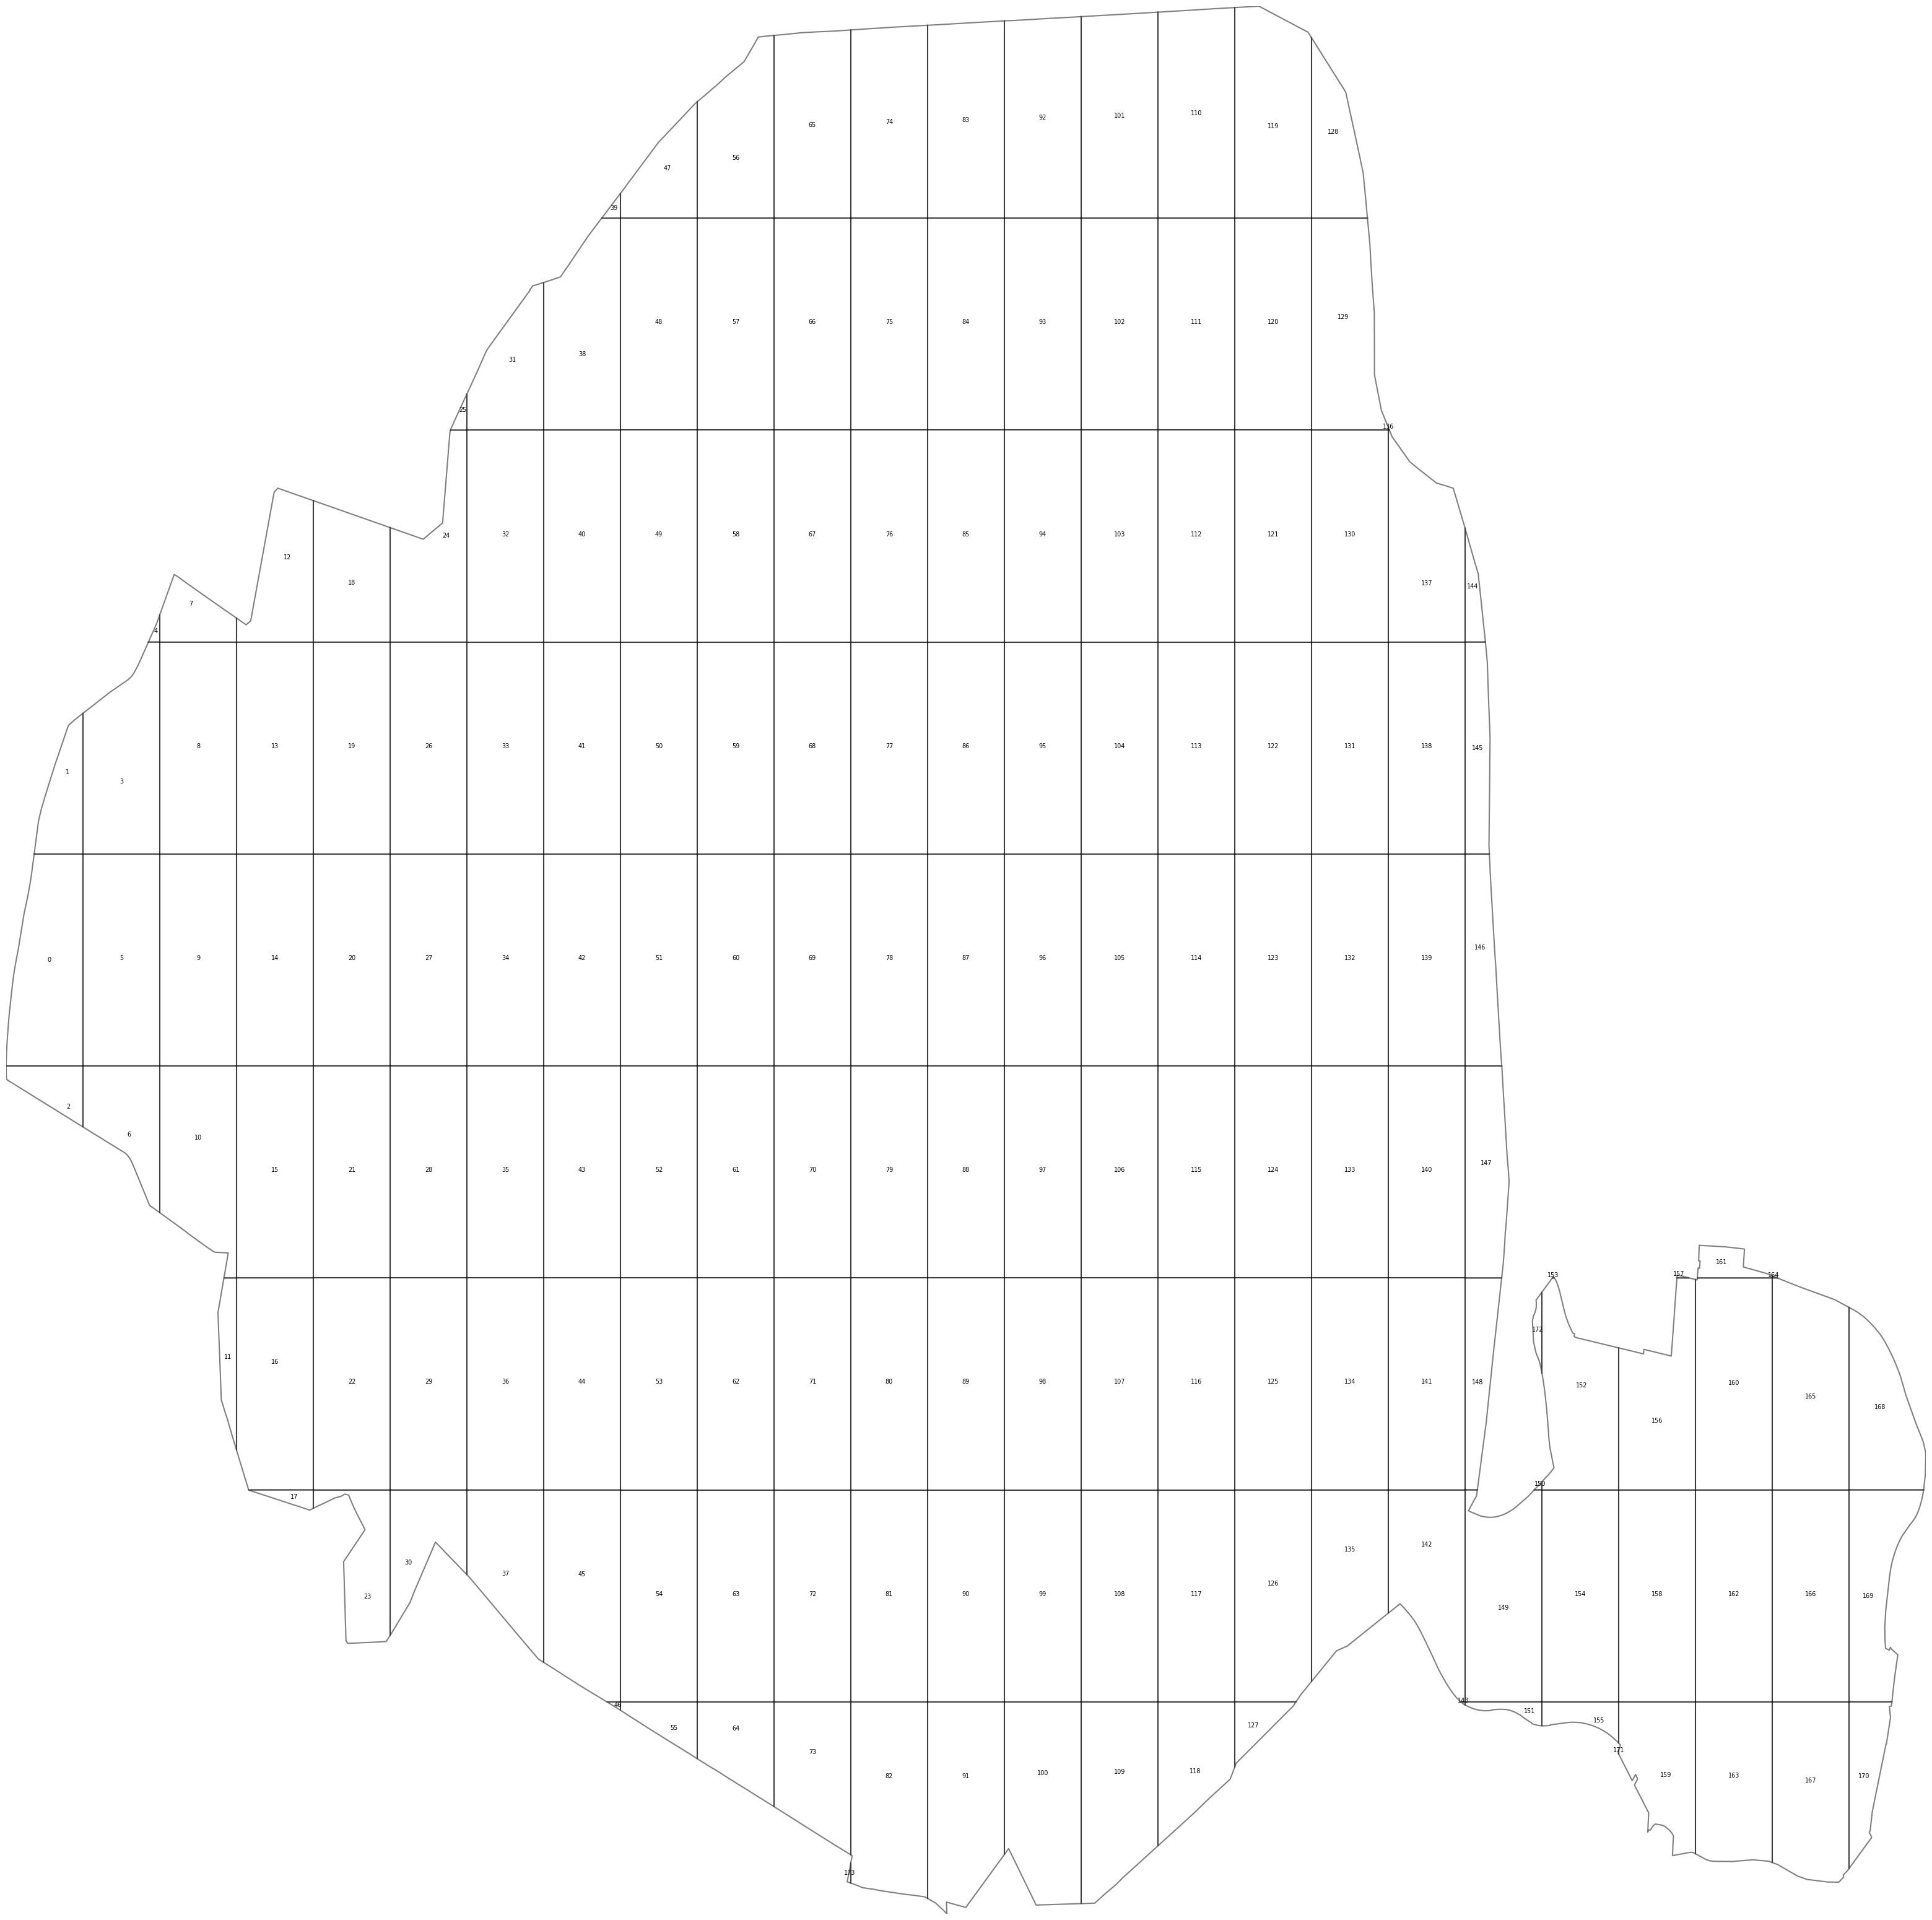

In [85]:
geometry_cut = ox.utils_geo._quadrat_cut_geometry(city_geometry, quadrat_width=grid_size)
plot_polygons_with_labels(geometry_cut)

In [86]:
# Crée une GeoDataFrame à partir d'une liste de polygones ('polylist') et l'associe à une colonne géométrique.
city_polyframe = gpd.GeoDataFrame(geometry=polylist)

# Définit le système de coordonnées (CRS - Coordinate Reference System) de la GeoDataFrame
# en utilisant le CRS de l'objet 'city' pour assurer la cohérence spatiale.
city_polyframe.crs = city.crs

# Affiche le CRS actuel de la GeoDataFrame, pour vérifier ou confirmer le système de coordonnées utilisé.
print(city_polyframe.crs)

# Affiche les premières lignes de la GeoDataFrame, permettant une inspection rapide des données.
print(city_polyframe.shape)
city_polyframe.head()


epsg:4326
(174, 1)


,geometry
0,"POLYGON ((2.22412 48.8542, 2.22416 48.85462, 2..."
1,"POLYGON ((2.2277 48.86368, 2.22795 48.86433, 2..."
2,"POLYGON ((2.23395 48.85406, 2.23395 48.85129, ..."
3,"POLYGON ((2.23395 48.87006, 2.23402 48.87008, ..."
4,"POLYGON ((2.24232 48.8733, 2.24336 48.87413, 2..."


In [87]:
def plot_geodataframe_with_basemap(gdf, target_epsg=3857, zoom=13, figsize=(10, 10)):
    """
    Visualise une GeoDataFrame avec un basemap, en projetant sur un CRS spécifique.

    Paramètres :
    - gdf : GeoDataFrame à visualiser.
    - target_epsg : EPSG pour reprojeter la GeoDataFrame (par défaut : 3857 pour Web Mercator).
    - zoom : Niveau de zoom pour le basemap (par défaut : 13).
    - figsize : Taille de la figure matplotlib (par défaut : (10, 10)).

    Retourne :
    - None (affiche la carte).
    """
    # Reprojeter la GeoDataFrame vers le CRS cible
    gdf_projected = gdf.to_crs(epsg=target_epsg)

    # Calculer les bornes dans le CRS projeté
    west, south, east, north = gdf_projected.unary_union.bounds

    # Créer le tracé
    fig, ax = plt.subplots(figsize=figsize)

    # Tracer la GeoDataFrame
    gdf_projected.plot(ax=ax, alpha=0.5, edgecolor='k')

    # Ajouter le basemap
    ctx.add_basemap(ax, crs=gdf_projected.crs, zoom=zoom)

    # Définir les limites de l'affichage (important après l'ajout du basemap)
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)

    # Supprimer les ticks et labels des axes pour un affichage plus propre
    ax.set_axis_off()

    # Afficher la carte
    plt.show()


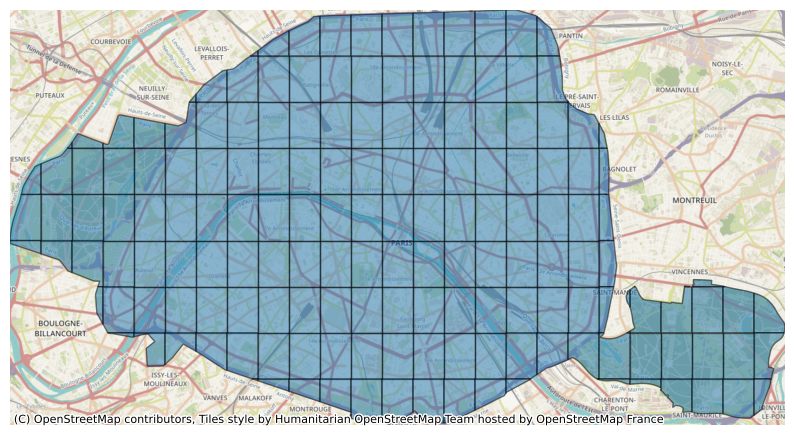

In [88]:
plot_geodataframe_with_basemap(city_polyframe)

Obtention des donnees sur Open Street Map

In [89]:
def get_osm_features(place_name, tags, crs="epsg:4326"):
    """
    Retrieve OpenStreetMap features for a specified place and return as a GeoDataFrame.

    Parameters:
        place_name (str): Name of the place to search (e.g., "Paris, France").
        tags (dict): Tags for filtering OSM features (e.g., {"amenity": "charging_station"}).
        crs (str): Target Coordinate Reference System for the output (default: "epsg:4326").

    Returns:
        GeoDataFrame: GeoDataFrame containing the requested OSM features.
    """
    try:
        # Retrieve OSM features matching the specified tags
        features = ox.features_from_place(place_name, tags=tags)

        # Filter to include only Point geometries (optional, based on your use case)
        features = features[features.geometry.type == 'Point']

        # Reproject to the specified CRS
        features.to_crs(crs, inplace=True)

        return features
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

In [90]:
def compter_entites_par_grille(grille, points_interet, nom_colonne_resultat):
    """
    Calcule le nombre d'entités dans chaque cellule de la grille géographique.

    :param grille: GeoDataFrame contenant les géométries des cellules de la grille.
    :param points_interet: GeoDataFrame contenant les géométries des points d'intérêt (restaurants, parcs, etc.).
    :param nom_colonne_resultat: Nom de la colonne à ajouter dans le GeoDataFrame `grille` pour les résultats.
    :return: GeoDataFrame avec une nouvelle colonne contenant le compte d'entités pour chaque cellule.
    """
    # Liste pour stocker les masques de présence
    masques_presence = []
    for index in tqdm(range(grille.shape[0]), desc="Calcul des masques de présence"):
        masque = points_interet.within(grille.loc[index, 'geometry'])
        masques_presence.append(masque)

    # Calcul du nombre d'entités par cellule
    compte_entites = []
    for index in tqdm(range(grille.shape[0]), desc="Calcul des comptes d'entités"):
        compte_entites.append(points_interet[masques_presence[index]].shape[0])

    # Ajout des résultats au GeoDataFrame
    grille[nom_colonne_resultat] = compte_entites
    return grille

In [91]:

def associer_geometries_par_grille(grille, points_interet, nom_colonne_geometries):
    """
    Associe les géométries des points d'intérêt à chaque cellule de la grille géographique.

    :param grille: GeoDataFrame contenant les géométries des cellules de la grille.
    :param points_interet: GeoDataFrame contenant les géométries des points d'intérêt (par exemple, stations EV, restaurants).
    :param nom_colonne_geometries: Nom de la colonne à ajouter dans le GeoDataFrame `grille` pour stocker les géométries.
    :return: GeoDataFrame avec une nouvelle colonne contenant les géométries des points d'intérêt sous forme de listes.
    """
    # Liste pour stocker les masques de présence
    masques_presence = []
    for index in tqdm(range(grille.shape[0]), desc="Calcul des masques de présence"):
        masque = points_interet.within(grille.loc[index, 'geometry'])
        masques_presence.append(masque)

    # Associer les géométries des points d'intérêt à chaque cellule
    geometries_associees = []
    for index in tqdm(range(grille.shape[0]), desc="Association des géométries"):
        geometries = points_interet[masques_presence[index]][['geometry']].values.tolist()
        geometries_associees.append(str(geometries))

    # Ajout des géométries associées au GeoDataFrame
    grille[nom_colonne_geometries] = geometries_associees
    return grille

In [92]:
city_polyframe_lat_long = city_polyframe.to_crs(epsg=4326)

# Les données collectes seront stockes dans Paris_df
paris_df = city_polyframe_lat_long.copy()

Collecte des données sur les stations électriques

In [93]:
# Collecter les données sur les stations 

ev_stations = get_osm_features(place_name = "Paris, France",tags = {"amenity": "charging_station"})


# Compter le nombre de station dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = ev_stations,
    nom_colonne_resultat='ev_stations_counts'
)

# Ajouter les coordonees des stations exitantes dans une grille (geometry)
# On le ferra uniquement pour les stations

paris_df = associer_geometries_par_grille(
    grille =paris_df,
    points_interet = ev_stations,
    nom_colonne_geometries = 'ev_stations_geometries'
)

Association des géométries: 100%|██████████| 174/174 [00:00<00:00, 984.08it/s]


In [94]:
# Si le grid_size est different de notre taille de depart elle pourrait ne pas marcher

paris_df.iloc[135:140]

,geometry,ev_stations_counts,ev_stations_geometries
135,"POLYGON ((2.40098 48.83482, 2.40098 48.82922, ...",6,"[[<POINT (2.399 48.831)>], [<POINT (2.399 48.8..."
136,"POLYGON ((2.40098 48.88304, 2.40112 48.88292, ...",0,[]
137,"POLYGON ((2.40112 48.88292, 2.40147 48.88261, ...",0,[]
138,"POLYGON ((2.41081 48.8733, 2.41081 48.86368, 2...",3,"[[<POINT (2.409 48.873)>], [<POINT (2.405 48.8..."
139,"POLYGON ((2.41081 48.86368, 2.41081 48.85406, ...",2,"[[<POINT (2.403 48.859)>], [<POINT (2.406 48.8..."


In [95]:
# Collecter les données sur les parking

parking = get_osm_features(place_name="Paris, France",tags = {"amenity": "parking"})

# Compter le nombre de parking dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = parking,
    nom_colonne_resultat='parking_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 1553.20it/s]


In [96]:
paris_df

,geometry,ev_stations_counts,ev_stations_geometries,parking_counts
0,"POLYGON ((2.22412 48.8542, 2.22416 48.85462, 2...",0,[],0
1,"POLYGON ((2.2277 48.86368, 2.22795 48.86433, 2...",0,[],0
2,"POLYGON ((2.23395 48.85406, 2.23395 48.85129, ...",0,[],0
3,"POLYGON ((2.23395 48.87006, 2.23402 48.87008, ...",0,[],0
4,"POLYGON ((2.24232 48.8733, 2.24336 48.87413, 2...",0,[],0
...,...,...,...,...
169,"POLYGON ((2.46948 48.83482, 2.46939 48.83461, ...",0,[],1
170,"POLYGON ((2.46542 48.8252, 2.46536 48.825, 2.4...",0,[],0
171,"POLYGON ((2.43046 48.82283, 2.43039 48.82288, ...",0,[],0
172,"POLYGON ((2.42063 48.84013, 2.4206 48.84019, 2...",0,[],0


In [97]:
# Collecter les données sur les restaurants

restaurant = get_osm_features(place_name="Paris, France",tags = {"amenity": "restaurant"})

# Compter le nombre de restaurant dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = restaurant,
    nom_colonne_resultat='restaurant_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 660.71it/s]


In [98]:
paris_df

,geometry,ev_stations_counts,ev_stations_geometries,parking_counts,restaurant_counts
0,"POLYGON ((2.22412 48.8542, 2.22416 48.85462, 2...",0,[],0,0
1,"POLYGON ((2.2277 48.86368, 2.22795 48.86433, 2...",0,[],0,0
2,"POLYGON ((2.23395 48.85406, 2.23395 48.85129, ...",0,[],0,0
3,"POLYGON ((2.23395 48.87006, 2.23402 48.87008, ...",0,[],0,1
4,"POLYGON ((2.24232 48.8733, 2.24336 48.87413, 2...",0,[],0,0
...,...,...,...,...,...
169,"POLYGON ((2.46948 48.83482, 2.46939 48.83461, ...",0,[],1,1
170,"POLYGON ((2.46542 48.8252, 2.46536 48.825, 2.4...",0,[],0,0
171,"POLYGON ((2.43046 48.82283, 2.43039 48.82288, ...",0,[],0,0
172,"POLYGON ((2.42063 48.84013, 2.4206 48.84019, 2...",0,[],0,0


In [99]:
# Collecter les données sur les librairies

library = get_osm_features(place_name="Paris, France",tags = {"amenity": "library"})

# Compter le nombre de librairies dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = library,
    nom_colonne_resultat='library_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 1874.41it/s]


In [100]:
# Collecter les données sur les universités

university = get_osm_features(place_name="Paris, France",tags = {"amenity": "university"})

# Compter le nombre d'universités dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = university,
    nom_colonne_resultat='university_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 2345.00it/s]


In [101]:
# Collecter les données sur les écoles 

school = get_osm_features(place_name="Paris, France",tags = {"amenity": "school"})

# Compter le nombre d'écoles dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = school,
    nom_colonne_resultat='school_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 2003.27it/s]


In [102]:
# Collecter les données sur les parc d'abstraction

park = get_osm_features(place_name="Paris, France",tags = {"leisure": "park"})

# Compter le nombre de parc dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = park,
    nom_colonne_resultat='park_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 2038.42it/s]


In [103]:
# Collecter les données sur les cinema

cinema = get_osm_features(place_name="Paris, France",tags = {"amenity": "cinema"})

# Compter le nombre de cinema dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = cinema,
    nom_colonne_resultat='cinema_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 1915.63it/s]


In [104]:
# Collecter les données sur les lieux de culte

place_of_worship = get_osm_features(place_name="Paris, France",tags = {"amenity": "place_of_worship"})

# Compter le nombre de lieux de culte dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = place_of_worship,
    nom_colonne_resultat='place_of_worship_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 1931.49it/s]


In [105]:
# Collecter les données sur les magasins de details

retail = get_osm_features(place_name="Paris, France",tags = {"building": "retail"})

# Compter les magasins de details dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = retail,
    nom_colonne_resultat='retail_counts'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 1631.15it/s]


In [106]:
# Collecter les données sur les magasins de commerce

commercial = get_osm_features(place_name="Paris, France",tags = {"building": "commercial"})

# Compter les magasins de commerce dans chaque grille

paris_df = compter_entites_par_grille(
    grille = paris_df,
    points_interet = commercial,
    nom_colonne_resultat='commercial'
)

Calcul des comptes d'entités: 100%|██████████| 174/174 [00:00<00:00, 2134.10it/s]


Le reseau routier

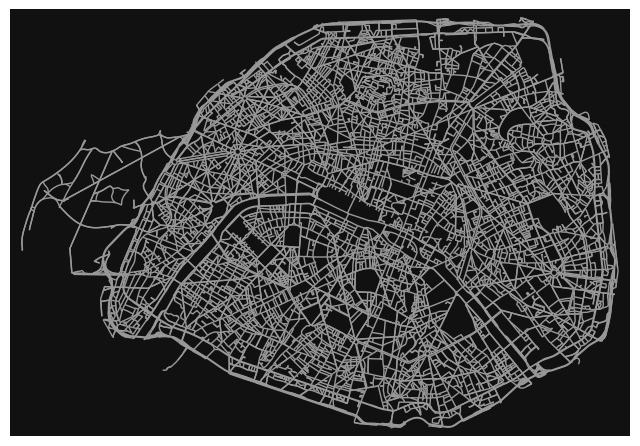

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [107]:
G = ox.graph_from_place('Paris, France', network_type='drive')
ox.plot_graph(G, node_size= 0)

In [108]:
# Collecter des informations surle reseau routier  

nodes = []    # Liste pour stocker le nombre de nœuds (intersections ou points du réseau routier)
edges = []    # Liste pour stocker le nombre d'arêtes (routes connectant les intersections)
density = []  # Liste pour stocker la densité du graphe (rapport entre les arêtes et nœuds possibles)

# Parcourir chaque cellule géographique dans le GeoDataFrame
for i in tqdm(range(0, city_polyframe_lat_long.shape[0])):
    try: 
        poly = city_polyframe_lat_long.loc[i, 'geometry']
        G = ox.graph_from_polygon(poly, network_type='drive')
        num_nodes = len(list(G.nodes()))
        nodes.append(num_nodes)
        num_edges = len(list(G.edges()))
        edges.append(num_edges)
        graph_density = nx.density(G)
        density.append(graph_density) 

    except Exception as e:
        # Si une erreur survient (par exemple, une géométrie invalide ou absence de données OSM),
        # stocker des valeurs par défaut (0) pour les nœuds, arêtes, et densité
        nodes.append(0)
        edges.append(0)
        density.append(0)

100%|██████████| 174/174 [01:02<00:00,  2.79it/s]


In [109]:
#ajouter les nœuds, arêtes, and densité au dataset
paris_df['nodes'] = nodes
paris_df['edges'] = edges
paris_df['road_density'] = density

La densite de la population

In [110]:
# Les donnees sur la densite de la population francaise est disponible sur ce site
# https://data.humdata.org/dataset/france-high-resolution-population-density-maps-demographic-estimates
# Contenu dans le fichier population_fra_2019-07-01_geotiff
# Nous n'avons pas ajoute cela sur github a cause de sa taille ( 2.1 GB)
# Toutefois nous avons recuperer uniquement celui de Paris ( sauvegarder dans le fichier paris_population.csv)


#df_pop = pd.read_csv("population_fra_2019-07-01.csv")
#gdf = gpd.GeoDataFrame(df_pop, geometry=gpd.points_from_xy(df_pop.Lon, df_pop.Lat))

# Obtention des donnees pour la ville de Paris

#city_lat_long = city.to_crs(epsg=4326)
#pip_mask = gdf.within(city_lat_long.loc[0, 'geometry'])
#paris_pop_gdf = gdf.loc[pip_mask]

#paris_pop_gdf.to_csv(f"paris_population.csv")

In [111]:
# Veuillez lancer cette ligne si vous n'aviez parfaitment executer la cellule precedente

df = pd.read_csv("paris_population.csv")

paris_pop_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['Lon'], df['Lat'])
)

In [112]:
# densite de la population dans chaque grille
masks_pop = []
for i in tqdm(range(0,city_polyframe_lat_long.shape[0])):
    pip_mask = paris_pop_gdf.within(city_polyframe_lat_long.loc[i, 'geometry'])
    masks_pop.append(pip_mask)


pop_grid = []
for i in range(0,city_polyframe_lat_long.shape[0]):
    pop_grid.append(paris_pop_gdf.loc[masks_pop[i]].Population.mean())

paris_df['pop_density'] = pop_grid

100%|██████████| 174/174 [00:00<00:00, 200.57it/s]


In [113]:
paris_df.columns

Index(['geometry', 'ev_stations_counts', 'ev_stations_geometries',
       'parking_counts', 'restaurant_counts', 'library_counts',
       'university_counts', 'school_counts', 'park_counts', 'cinema_counts',
       'place_of_worship_counts', 'retail_counts', 'commercial', 'nodes',
       'edges', 'road_density', 'pop_density'],
      dtype='object')

Valeurs manquantes 

In [114]:
# Veifier s'il y'a des valeurs manquantes dans chaque ligne

paris_df.isnull().sum()

geometry                   0
ev_stations_counts         0
ev_stations_geometries     0
parking_counts             0
restaurant_counts          0
library_counts             0
university_counts          0
school_counts              0
park_counts                0
cinema_counts              0
place_of_worship_counts    0
retail_counts              0
commercial                 0
nodes                      0
edges                      0
road_density               0
pop_density                7
dtype: int64

In [115]:
# Les valeurs des densite nulle ce sont des zones inhabitables dont on remplace cela par O

paris_df.fillna(0, inplace=True)

Sauvegarder notre dataset dans un format CSV

In [116]:
# save the dataframe
paris_df.to_csv(f"paris_df.csv")